# Plot full North American DTA tree with baltic

August 15, 2019

This notebook contains code for producing the full North American tree, generated by running all North American genomes though Beast 1.8 with a skygrid population size prior, and inferring migration history with DTA for all 22 US states/Canadian provinces. This will produce the tree in Figure 1a. 

In [1]:
import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp
bt = imp.load_source('baltic', '../../baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap

import numpy as np
from scipy.special import binom

In [2]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [6]:
# set path to tree to load 
tree_path = "../beast/output/mumps-NA-DTA-skygrid-25-2020-01-16.mcc.tree"

In [7]:
# load trees
tree = bt.loadNexus(tree_path)
tree.setAbsoluteTime(2018.0)#tree_path = "/Users/lmoncla/Documents/Mumps/beast/DTA/2020-01-16-skygrid-36/mcc.tree"

In [5]:
# set output filename
filename = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/individual-PDFs/full-NA-DTA-tree-skygrid-25-2020-09-15.pdf"

In [16]:
# parse leaf and node information into a dictionary for plotting
metadata = {}
node_types = {}
node_probs = {}

for k in tree.Objects: ## iterate over objects in tree
    if k.branchType=='leaf':
        division = k.traits['division']
        metadata[k] = {}
        metadata[k]["division"] = division
        node_probs[k] = k.traits["division.prob"]
    
    # parse the nodes now and pick out the type trait
    if k.branchType=='node':
        node_division = k.traits["division"]
        node_types[k] = {}
        node_types[k]["division"] = node_division
        node_probs[k] = k.traits["division.prob"]

In [17]:
colors = {"british_columbia":"#3C285C",
          "california":"#471A93",
          "new_york":"#4928B4",
          "virginia":"#3F50CC",
          "georgia":"#273B82",
          "manitoba":"#597ED4",
          "arkansas":"#EEA160",
          "north_dakota":"#5098B9",
          "massachusetts":"#396867",
          "missouri":"#5CA7A4",
          "ontario":"#B2313D",
          "pennsylvania":"#588755",
          "texas":"#7CB878",
          "indiana":"#A4BE56",
          "michigan":"#FDBB29",
          "north_carolina":"#D4749B",
          "new_hampshire":"#FED479",
          "ohio":"#DAAC3D",
          "washington":"#2664A5",
          "illinois":"#EABACD",
          "kansas":"#D84F07",
          "new_jersey":"#DF4027",
          "montana":"#85252E",
          "wisconsin":"#59191E",
          "iowa":"#E77720",
          "alabama":"#D84F07",
          "louisiana":"#C82722"}

uncertainty_color = "#B9B9B9"

In [18]:
division_order = ["british_columbia","california","new_york","georgia","virginia","manitoba","washington",
                  "north_dakota","massachusetts","missouri","pennsylvania","texas","indiana","ohio","michigan",
                  "new_hampshire","arkansas",'iowa',"kansas","new_jersey",
                  "louisiana","ontario","montana","wisconsin","north_carolina","illinois"]  

In [ ]:
colors = clr.LinearSegmentedColormap.from_list('custom ', [Not_Marshallese_color,Marshallese_color], N=256)
uncertainty_color = "#B9B9B9"

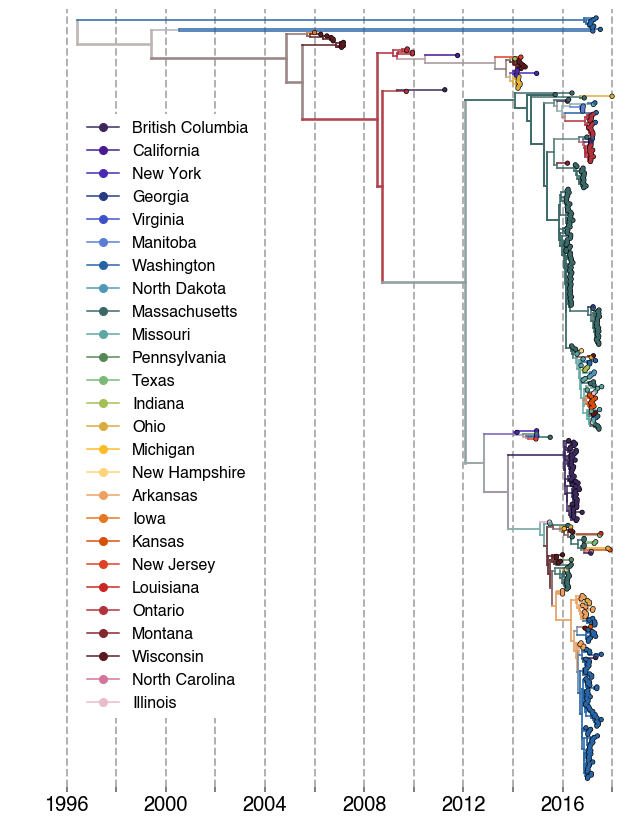

In [24]:
fig,ax = plt.subplots(figsize=(10,12),facecolor='w')

# # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
dates_ls = []
for i in range(1996,2020):
    dates_ls.append(i)  
dates = dates_ls[::2]
[ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in dates]

# set date labels to be every 4
date_labels = []
for d in dates_ls[::4]:
    date_labels.append(str(d))
    if d < 2018:
        date_labels.append("")

branchWidth=1.5 ## default branch width
tipSize = 15

# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## or use absolute time instead
    y=k.y 
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        base_color=colors[metadata[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color,base_color], N=256)
        c = color_ramp(node_probs[k])
        s=tipSize
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        base_color=colors[node_types[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color, base_color], N=256)
        c = color_ramp(node_probs[k])
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        
    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
        
    # add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in division_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
    han_list.append(marker)

# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_ylim(-5,tree.ySpan+5)
ax.set_xlim(1993.8,2018.2)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
ax.set_xticks(dates)
ax.set_xticklabels(date_labels)   # set date labels every 4
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.1, 0.08], loc=3,prop={'size': 16}, facecolor='w')

fig.tight_layout()
plt.gcf().subplots_adjust(right=0.88)
plt.savefig(filename)

plt.show()

## Plot a wide version for slides

In [10]:
filename2 = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/individual-PDFs/full-NA-DTA-tree-wide-2020-02-03.pdf"

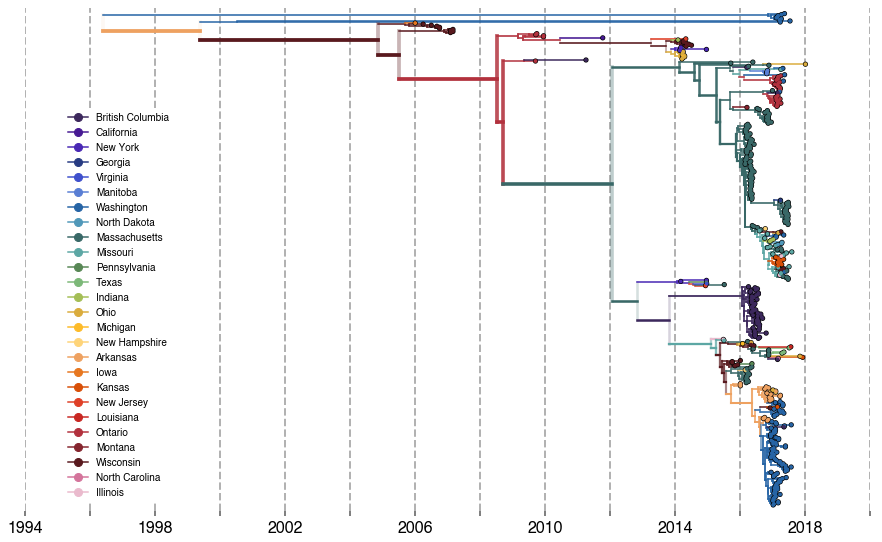

In [11]:
fig,ax = plt.subplots(figsize=(14,8),facecolor='w')

# # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
dates_ls = []
for i in range(1994,2022):
    dates_ls.append(i)  
dates = dates_ls[::2] 
[ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in dates]

# set date labels to be every 4
date_labels = []
for d in dates_ls[::4]:
    date_labels.append(str(d))
    if d < 2018:
        date_labels.append("")

branchWidth=1.5 ## default branch width
tipSize = 15

# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    #   x=k.x ## or from x position determined earlier
    x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    
#   xp=k.parent.x ## get x position of current object's parent
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
#     c='indianred' ## colour can be fixed
#     c=cmap(k.height/ll.treeHeight) ## or be a function of something else
#     c=[cmap(k.traits['posterior']) if k.traits.has_key('posterior') else cmap(1.0)][0]
    
    #c=['#63C78A' if k.traits['geo']=='cambodia' else '#6A34CA'][0] ## can be discrete too
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        c=colors[metadata[k]["division"]]
        s=tipSize ## tip size can be fixed
        #=150-50*k.height/tree.treeHeight
        
        # plot tip labels
        #ax.text(x+30/365.0,y,'%s'%(k.name.split("|")[1]),ha='left',va='center',size=12,color=c) 

        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.005
        c=colors[node_types[k]["division"]]
        a=node_probs[k]
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,alpha=a,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        
    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
        
    # add in a legend
    han_list = []

    
    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
    #ax.legend(handles = han_list, markerfirst = True, frameon=False, bbox_to_anchor=[0.8, 1], loc=2, prop={'size': 24})
for key in division_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
    han_list.append(marker)

# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_ylim(-5,tree.ySpan+5)
ax.set_xlim(1994,2020)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=16,size=5, width=2,color='grey')
ax.set_xticks(dates)
ax.set_xticklabels(date_labels)
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.04, 0.01], loc=3,prop={'size': 10}, facecolor='w')

fig.tight_layout()
plt.gcf().subplots_adjust(right=0.88)
plt.savefig(filename2)

plt.show()